# Описание проекта

Нужно провести анализ гипотез для увеличения выручки крупного интернет-магазина. Гипотезы подготовлены отделом маркетинга совместно с отделом аналитики.

Основные задачи:
   - Приоритизировать гипотезы
   - Анализ A/B-теста

Данные:
  - 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
  - Результаты проведённых A/B-тестов.

# Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
import datetime as dt
import seaborn as sns
pd.set_option("display.float_format", "{:.2f}".format)
pd.options.display.max_colwidth = 1

# Загружаем данные

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv')
)

## Описание и обзор данных

Структура /datasets/hypothesis.csv:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 

Структура /datasets/orders.csv:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура /datasets/visitors.csv:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [3]:
for a in [hypothesis, orders, visitors]:
    display(a.sample())
    display(a.info())
    print('количество дубликатов:', a.duplicated().sum())

,Hypothesis,Reach,Impact,Confidence,Efforts
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

количество дубликатов: 0


,transactionId,visitorId,date,revenue,group
550,3894221956,3584855583,2019-08-29,9750,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

количество дубликатов: 0


,date,group,visitors
8,2019-08-09,A,617


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

количество дубликатов: 0


В данных отсутствуют дубликаты и пропуски. Но даты имеют неудобный тип данных и нужно немного поправить регистр.

In [4]:
for a in [hypothesis]:
    a.columns = [b.lower() for b in a.columns.values]
orders.columns = [x.replace('Id', '_id') for x in orders.columns.values] 
    
orders['date'] = pd.to_datetime(orders['date']).dt.date
visitors['date'] = pd.to_datetime(visitors['date']).dt.date

display(orders.sample(), hypothesis.sample())

,transaction_id,visitor_id,date,revenue,group
230,3124204494,2927087541,2019-08-23,27550,A


,hypothesis,reach,impact,confidence,efforts
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3


 ## Приоритезация гипотез

In [5]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [6]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


In [7]:
display(hypothesis[['hypothesis','RICE','ICE']].sort_values(by='RICE', ascending=False).head(5))

,hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00,7.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00,8.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20


Гипотезы под номерами 8, 7, 6, 2, 0 входят в топ 5 обоих методов. Гипотеза номер 7 набрала большее количество баллов по методу RICE, потому что имеет максимальный охват среди прочих. По методу ICE она на входит в топ 3 с небольшим отрывом по количеству набранных баллов. Гипотеза номер 8 набравшая максимальное количество баллов по методу ICE теоретически может иметь тоже большой охват. Но это не произойдёт единовременно.

## Анализ A/B-теста

В данные могли попасть пользователи, которые совершили покупку в обоих группах, проверим.

In [8]:
doubles = orders.groupby(['visitor_id']).agg({'group' : 'nunique', 'transaction_id' : 'count', 'revenue' : 'sum'}).reset_index()
print(f"Пользователей, попавших в обе группы: {doubles[doubles.group != 1]['visitor_id'].count()}")
print(f"Сумма заказов этих пользователей: {doubles[doubles.group != 1]['revenue'].sum()}")
print(f"Количество заказов: {doubles[doubles.group != 1]['transaction_id'].sum()}")

Пользователей, попавших в обе группы: 58
Сумма заказов этих пользователей: 1558935
Количество заказов: 181


Поскольку нам неизвестно какая из версий страницы оказала влияние на принятие решения о покупке, отсеем этих пользователей из дальнейшего анализа.

In [9]:
filtred_id = doubles[doubles.group != 1]['visitor_id']
display(orders['visitor_id'].nunique())
orders = orders.query('visitor_id not in @filtred_id')
display(orders['visitor_id'].nunique())

1031

973

### Построим график кумулятивной выручки по группам

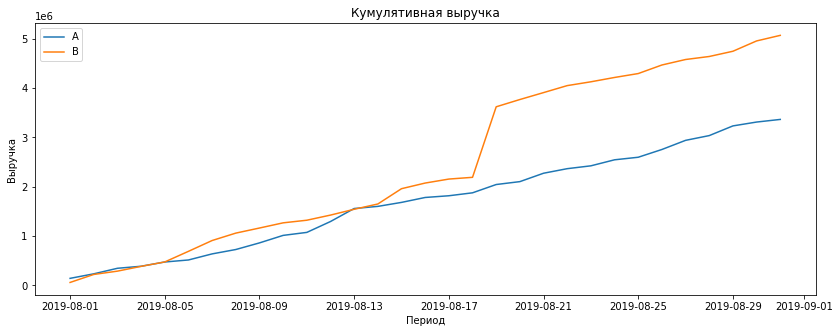

In [10]:
dates_groups = orders[['date','group']].drop_duplicates()
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitors_agg = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cmltv_data = orders_aggregated.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cmltv_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cmltv_revenue_a = cmltv_data[cmltv_data['group']=='A'][['date','revenue', 'orders']]
cmltv_revenue_b = cmltv_data[cmltv_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(14, 5))
plt.plot(cmltv_revenue_a['date'], cmltv_revenue_a['revenue'], label='A')
plt.plot(cmltv_revenue_b['date'], cmltv_revenue_b['revenue'], label='B')
plt.title('Кумулятивная выручка')
plt.xlabel('Период')
plt.ylabel('Выручка')
plt.legend() 
plt.show()

Во второй половине августа выручка категории В сильно вырывается вперёд и продолжает лидировать до окончания теста. Вероятно влияние оказал аномально большой заказ.

### Построим график кумулятивного среднего чека по группам

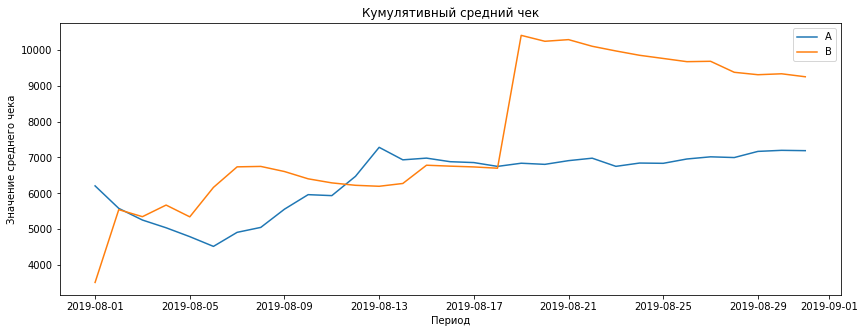

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(cmltv_revenue_a['date'], cmltv_revenue_a['revenue']/cmltv_revenue_a['orders'], label='A')
plt.plot(cmltv_revenue_b['date'], cmltv_revenue_b['revenue']/cmltv_revenue_b['orders'], label='B')
plt.title('Кумулятивный средний чек')
plt.xlabel('Период')
plt.ylabel('Значение среднего чека')
plt.legend()
plt.show()

Видны колебания значений кумулятивного среднего чека, хотя в районе середины теста значения показывают равномерное сближение. И снова во второй половине августа сильный скачок роста у группы В.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

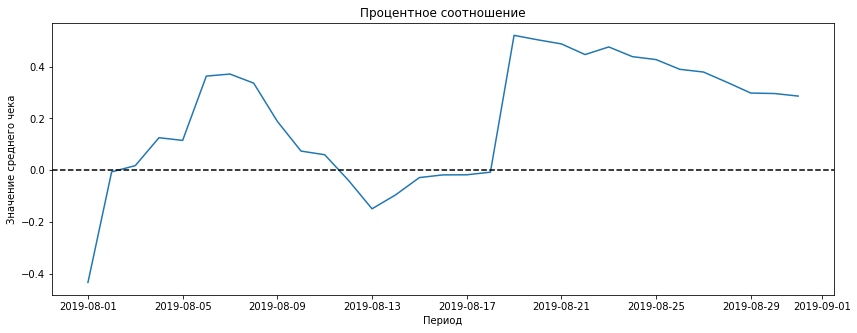

In [12]:
merged_cmltv_revenue = cmltv_revenue_a.merge(cmltv_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14, 5))
plt.plot(merged_cmltv_revenue['date'], (merged_cmltv_revenue['revenueB']/merged_cmltv_revenue['ordersB'])/(merged_cmltv_revenue['revenueA']/merged_cmltv_revenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Период')
plt.ylabel('Значение среднего чека')
plt.title('Процентное соотношение')
plt.show()

На графике видны значительные и резкие изменения. Результат с сильным ростом во второй половине месяца снова виден.

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

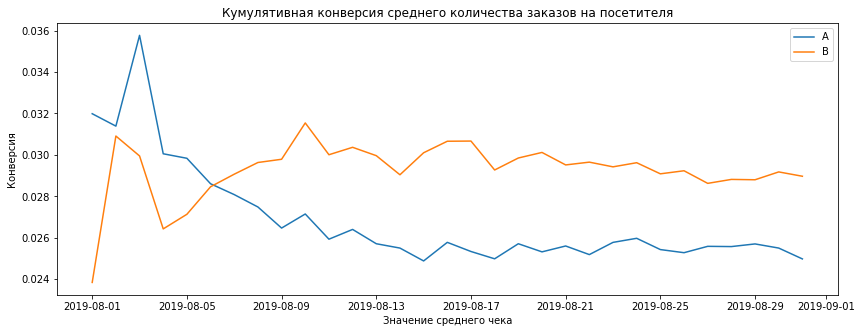

In [13]:
cmltv_data['conversion'] = cmltv_data['orders']/cmltv_data['visitors']

cmltv_data_a = cmltv_data[cmltv_data['group']=='A']

cmltv_data_b = cmltv_data[cmltv_data['group']=='B']

plt.figure(figsize=(14, 5))
plt.plot(cmltv_data_a['date'], cmltv_data_a['conversion'], label='A')
plt.plot(cmltv_data_b['date'], cmltv_data_b['conversion'], label='B')
plt.legend()
plt.xlabel('Значение среднего чека')
plt.ylabel('Конверсия')
plt.title('Кумулятивная конверсия среднего количества заказов на посетителя')
plt.show()

Обе группы начали тест с разных значений. Далее группа A показывает снижение результата. Обе группы постепенно стабилизируются. Конверсия среднего количества заказов в группе В выглядит лучше.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

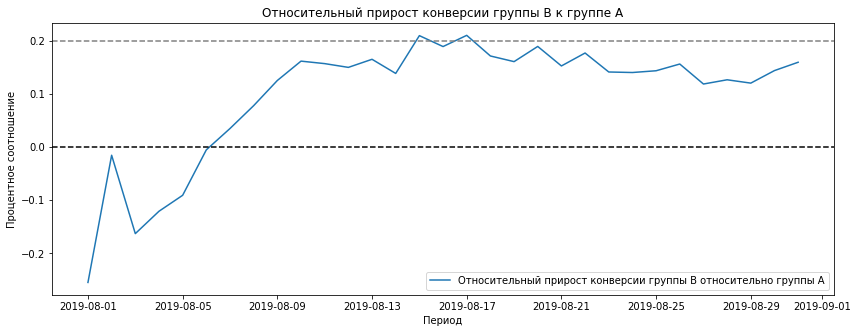

In [14]:
merged_cmltv_conversions = cmltv_data_a[['date','conversion']].merge(cmltv_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(14, 5))
plt.plot(merged_cmltv_conversions['date'], merged_cmltv_conversions['conversionB']/merged_cmltv_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.xlabel('Период')
plt.ylabel('Процентное соотношение')
plt.title('Относительный прирост конверсии группы B к группе A')
plt.show()

Группа В показывает лучшую конверсию относительно группы А. В отдельных моментах превышает отметку в 20% и держится около этого значения.

Графики кумулятивных метрик и их изменений позволяют предположить, что в группе B есть аномально большие заказы, которые сильно влияют на прирост среднего чека.

### Построим точечный график количества заказов по пользователям

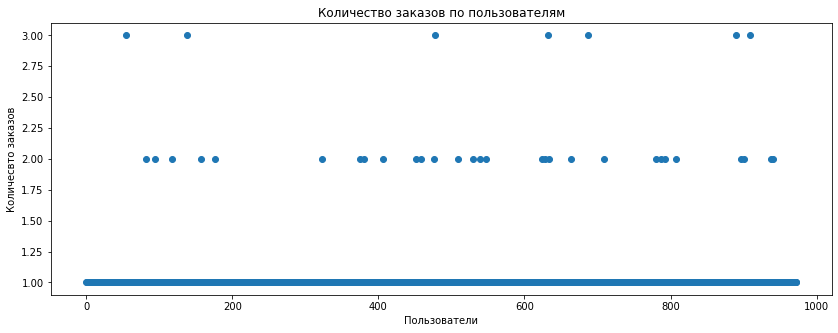

In [15]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['visitor_id', 'orders']

plt.figure(figsize=(14, 5))
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])
plt.xlabel('Пользователи')
plt.ylabel('Количесвто заказов')
plt.title('Количество заказов по пользователям')
plt.show()

Приемущественно пользователи сделали 1 заказ, но некоторые - 2. 3 заказа сделали всего 7 человек.

### 95-й и 99-й перцентили количества заказов на пользователя

In [16]:
print("95-й и 99-й перцентили количества заказов на пользователя:", np.percentile(orders_by_users['orders'], [95, 99])) 
print('Доля пользователей, кторые оформили больше 1 заказа:','{:.2%}'.format(len(orders_by_users[orders_by_users['orders'] > 1]) / len(orders_by_users)))

95-й и 99-й перцентили количества заказов на пользователя: [1. 2.]
Доля пользователей, кторые оформили больше 1 заказа: 3.70%



Пользователей оформивших один заказ подавляющее большенство, более 96%. Следует отсеять как аномальных пользователей с 2 и 3 заказами.

### Построим точечный график стоимостей заказов

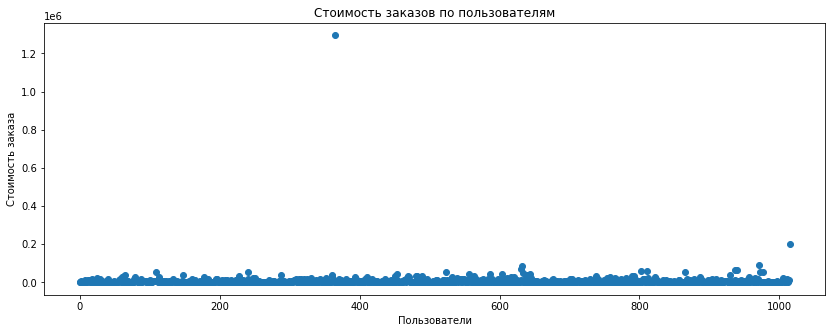

In [17]:
plt.figure(figsize=(14, 5))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость заказов по пользователям')
plt.show()

График показывает, что заказов с аномальной стоимостью не так много. Один "очень" аномальный заказ на сумму более 1 млн.
Масштабируем график по стоимости заказа чтобы увидеть данные более предметно.

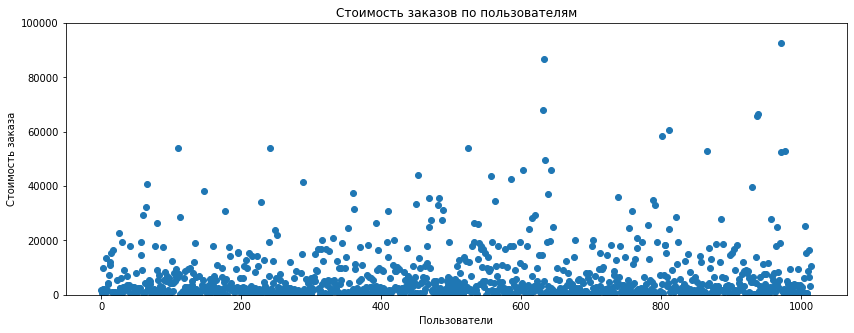

In [18]:
plt.figure(figsize=(14, 5))
plt.scatter(x_values, orders['revenue']) 
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.ylim([0,100000])
plt.show()

На графике видно, что в основном стомисоть заказов скапливается у значений около 5 тысяч. Посмотрим на цифры в деталях.

In [19]:
display(orders['revenue'].describe(percentiles=[0.95, 0.99]))

count   1016.00   
mean    8300.81   
std     42121.99  
min     50.00     
50%     2955.00   
95%     26785.00  
99%     53904.00  
max     1294500.00
Name: revenue, dtype: float64

50% заказов по сумме не превышают 2955. 95% заказов до 26785. Всё что выше 27000 можно считать аномальными.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Соберём списки для анализа конверсии по группамю.

In [20]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_pdate_a']

visitors_a_cmltv = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_pdate_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cmltv.columns = ['date', 'visitors_a_cmltv']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_pdate_b']

visitors_b_cmltv = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_pdate_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cmltv.columns = ['date', 'visitors_cmltv_b']


orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)



orders_daily_a.columns = ['date', 'orders_pdate_a', 'revenue_pdate_a']

orders_a_cmltv = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_pdate_a': 'sum', 'revenue_pdate_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cmltv.columns = [
    'date',
    'orders_cmltv_a',
    'revenue_cmltv_a',
]

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_pdate_b', 'revenue_pdate_b']

orders_b_cmltv = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_pdate_b': 'sum', 'revenue_pdate_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cmltv.columns = [
    'date',
    'orders_cmltv_b',
    'revenue_cmltv_b',
]


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cmltv, left_on='date', right_on='date', how='left')
    .merge(orders_b_cmltv, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cmltv, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cmltv, left_on='date', right_on='date', how='left')
)

orders_by_user_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_user_a.columns = ['visitor_id', 'orders']

orders_by_user_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_user_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat([orders_by_user_a['orders'],pd.Series(0, index=np.arange(data['visitors_pdate_a'].sum() - len(orders_by_user_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_user_b['orders'],pd.Series(0, index=np.arange(data['visitors_pdate_b'].sum() - len(orders_by_user_b['orders'])), name='orders')],axis=0)

Для анализа данных используем непараметрический тест Уилкоксона-Манна-Уитни, так как есть выбивающиееся значения, которые могут повлиять на результат. Уровень статистической значимости установим 0.05

В дальнейших тестах будем проверять следующие гипотезы:
 - Нулевая гипотеза H0 - статистически значимых различий в конверсии между группами нет.

 - Гипотеза H1 - статистически значимые различия есть.

In [21]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print('Относительный прирост:', round((sample_b.mean() / sample_a.mean() - 1)*100),'%')

p-value: 0.011
Относительный прирост: 16 %


По "сырым" данным есть различия между группами A и B: p-value меньше 0.05. Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, следует отвергнуть. Относительный прирост среднего группы В к конверсии группы А 16%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [22]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Различие в среднем чеке:", round((orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)*100),'%') 

p-value: 0.829
Различие в среднем чеке: 29 %


Различий по сырым данным между средними чеками: P-value значительно больше 0.05. Нет оснований отвергать нулевую гипотезу. Средний чек группы А значительно ниже среднего чека группы В.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Отфильтруем аномальных пользователей.

In [23]:
users_with_many_orders = pd.concat(
    [
        orders_by_user_a[orders_by_user_a['orders'] > 1]['visitor_id'],
        orders_by_user_b[orders_by_user_b['orders'] > 1]['visitor_id'],
    ],
    axis=0,
)
users_with_exp_orders = orders[orders['revenue'] > 27000]['visitor_id']
abnorm_users = (
    pd.concat([users_with_many_orders, users_with_exp_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sample_a_fitred= pd.concat(
    [
        orders_by_user_a[
            np.logical_not(orders_by_user_a['visitor_id'].isin(abnorm_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_pdate_a'].sum() - len(orders_by_user_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_fitred = pd.concat(
    [
        orders_by_user_b[
            np.logical_not(orders_by_user_b['visitor_id'].isin(abnorm_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_pdate_b'].sum() - len(orders_by_user_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print(abnorm_users.head(5))
print("Количество анормальных пользователей:", abnorm_users.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64
Количество анормальных пользователей: 86


In [24]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(sample_a_fitred, sample_b_fitred)[1]))
print('Относительный прирост:', round((sample_b_fitred.mean()/sample_a_fitred.mean()-1)*100),'%')

p-value: 0.016
Относительный прирост: 17 %


Различия между группами A и B по "очищенным" данным есть: p-value меньше 0.05. Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, следует отвергнуть. Относительный прирост среднего группы В к конверсии группы А 17,4%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [25]:
print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnorm_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnorm_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Различие в среднем чеке:", round((
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnorm_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnorm_users)),
            )
        ]['revenue'].mean()
        - 1
    )*100),'%'
)

p-value: 0.727
Различие в среднем чеке: -3 %


Уровень P-value стал ниже, но остался больше 0.05. Отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, по-прежнему нет. Средний чек группы B без шума стал ниже среднего чека группы A

# Выводы
 - Гипотеза под номером 7 за счёт максимального охвата среди прочих имеет высший приоритет.
 
 - Как по сырым данным, так и по отфильтрованным данным есть статистически различие по конверсии между группами.

 - Несмотря на фильтрацию аномальных заказов, статистически значимого различия по среднему чеку между группами нет.

 - Группа B имеет лучшее среднее количества заказов на посетителя , чем у группы A: график различия конверсии между группами показываетимеют тенденцию к росту, либо стабильность около среднего значения.

 - Тест можно остановить. Виден прирост конверсии в группе B, но на среднем чеке проверяемая гипотеза не сказалась.
 
 Рекоммендация: 
 
 отрегулировать работу правильного логирования пользователей, что бы исключить в дальнейшем пересечение групп.